# 目標
- Weak-constraint 4D-Varコードの実装
- 二次変分によるパラメータと状態変数の信頼区間推定 ← 途中
- 黒田研実データへの適用
- システムノイズ(なし/あり)固定区間スムーザーの実装


## Lorenz 96 model with system noise

## 強拘束4D-Varでは同化できないケースがある

T 1.0
day 5.0


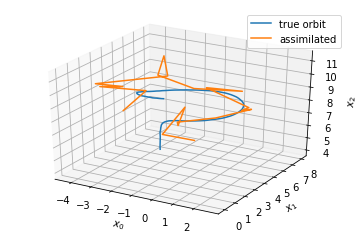

Before assimilation
cost 2083.23467905


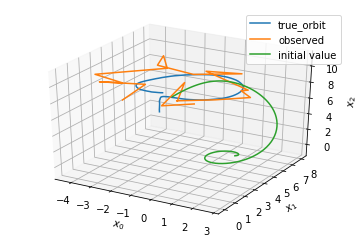

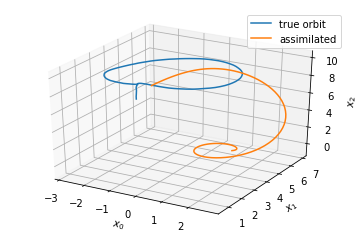

Analytical and numerical gradient comparison
gr_anal [ 272.270513     99.66576173   70.11973414  212.59976756  103.69304698
 -122.98326431   35.4607316 ]
gr_num [ 259.31905409  100.50675803   59.57522467  173.1526224    72.23639314
 -120.85575405   44.89635929]
relative error [ 0.04994411 -0.00836756  0.17699488  0.2278172   0.43546822  0.01760372
 -0.21016465]
      fun: 802.48039941927414
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.87675387, -2.00122102,  1.08416219,  1.79753237,  3.5954467 ,
        2.57811985, -5.05212731])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 140
      nit: 33
   status: 2
  success: False
        x: array([-4.55147395,  3.0547029 ,  3.51783399,  3.19872846, -1.28215436,
        2.85425409,  3.27662751])
true x0 [-2.718911  5.419507  3.693462  0.986995  2.82212   8.168231  4.972515]


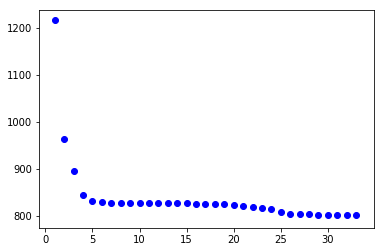

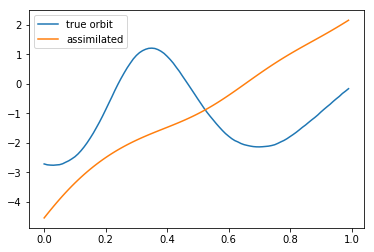

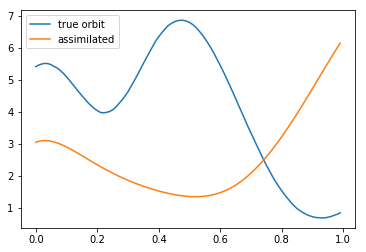

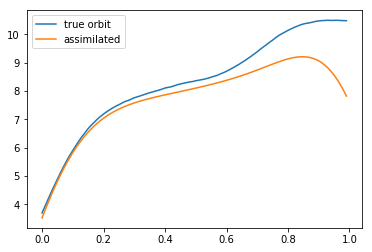

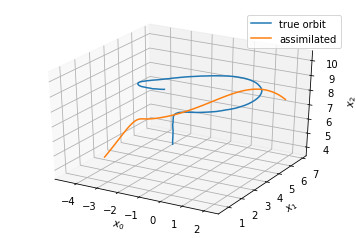

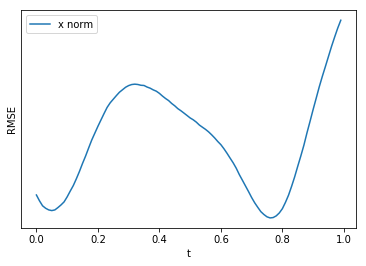

RMSE:  3.37714633006
4DVar optimal cost:  802.480399419
true cost:  58.783210153


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 14 17:01:40 2017

@author: yk
"""

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import math

def handler(func, *args):
    return func(*args)

#%%
class Lorenz96:
    def __init__(self, N, F):
        self.N = N
        self.F = F
    def gradient(self,x):
        d = np.zeros(self.N)
        d[0] = (x[1] - x[self.N-2]) * x[self.N-1] - x[0]
        d[1] = (x[2] - x[self.N-1]) * x[0]- x[1]
        d[self.N-1] = (x[0] - x[self.N-3]) * x[self.N-2] - x[self.N-1]
        for i in range(2, self.N-1):
            d[i] = (x[i+1] - x[i-2]) * x[i-1] - x[i]
        return d + self.F
        
    def gradient_adjoint(self, la, x):
        mt = np.zeros((self.N,self.N))
        for i in range(self.N):
            for j in range(self.N):
                if (((i-1) % self.N) == (j % self.N)):
                    mt[j][i] += x[(i+1) % self.N] - x[(i-2) % self.N]
                if (((i+1) % self.N) == (j % self.N)):
                    mt[j][i] += x[(i-1) % self.N]
                if (((i-2) % self.N) == (j % self.N)):
                    mt[j][i] -= x[(i-1) % self.N]
                if ((i     % self.N) == (j % self.N)):
                    mt[j][i] -= 1
        gr = mt @ la
        return gr

class RungeKutta4:
    def __init__(self, callback, N, dt, t, x):
        self.callback = callback
        self.N = N
        self.dt = dt
        self.t = t
        self.x = x

    def nextstep(self):
        k1 = handler(self.callback, self.x)
        k2 = handler(self.callback, self.x + k1*self.dt/2)
        k3 = handler(self.callback, self.x + k2*self.dt/2)
        k4 = handler(self.callback, self.x + k3*self.dt)
        self.t += self.dt
        self.x += (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
        return self.x
    
    def orbit(self,T):
        steps = int(T/self.dt) + 1
        o = np.zeros((steps,self.N))
        o[0] = self.x
        for i in range(steps):
            o[i] = self.nextstep()
        return o
    
    def nextstep_gradient(self):
        self.nextstep()
        return self.dt * self.callback(self.t, self.x)
    
    def orbit_gradient(self, T):
        steps = int(T/self.dt)
        gr = np.zeros((steps,N))
        gr[0] = self.dt * self.callback(self.t, self.x)
        for i in range(steps):
            gr[i] = self.nextstep_gradient()
        return gr

class Adjoint:
    def __init__(self, dx, dla, N, T, dt, it, x, y):
        self.dx = dx
        self.dla = dla
        self.N = N
        self.T = T
        self.dt = dt
        self.x = x
        self.y = y
        self.it = it
        self.minute_steps = int(T/self.dt)
        self.steps = int(self.minute_steps/it)
        
    def orbit(self):
        for i in range(self.minute_steps-1):
            k1 = handler(self.dx, self.x[i])
            k2 = handler(self.dx, self.x[i] + k1*self.dt/2)
            k3 = handler(self.dx, self.x[i] + k2*self.dt/2)
            k4 = handler(self.dx, self.x[i] + k3*self.dt)
            self.x[i+1] = self.x[i] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
        return self.x
    
    def observed(self, stddev):
        self.orbit()
        for i in range(self.steps):
            for j in range(self.N):
                self.x[i,j] += stddev * np.random.randn() # fixed
        return self.x

    def true_observed(self, stddev):
        tob = np.copy(self.orbit())
        for i in range(self.steps):
            for j in range(self.N):
                self.x[i,j] += stddev * np.random.randn() # fixed
        return tob, self.x
    
    def gradient(self):
        la = np.zeros((self.minute_steps, self.N))
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                if (n < self.it*self.steps - 1):
                    p1 = handler(self.dx, self.x[n])
                    p2 = handler(self.dx, self.x[n] + p1*self.dt/2)
                    p3 = handler(self.dx, self.x[n] + p2*self.dt/2)
                    p4 = handler(self.dx, self.x[n] + p3*self.dt)
                    gr = (p1 + 2*p2 + 2*p3 + p4)/6
    
                    k1 = handler(self.dla, la[n+1], self.x[n+1])
                    k2 = handler(self.dla, la[n+1] - k1*self.dt/2, self.x[n+1] - gr*self.dt/2)
                    k3 = handler(self.dla, la[n+1] - k2*self.dt/2, self.x[n+1] - gr*self.dt/2)
                    k4 = handler(self.dla, la[n+1] - k3*self.dt, self.x[n])
                    la[n] = la[n+1] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
            la[self.it*i] += self.x[self.it*i] - self.y[i]
        return la[0]

    def gradient_from_x0(self, x0):
        self.x[0] = x0
        self.orbit()
        la = np.zeros((self.minute_steps, self.N))
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                if (n < self.it*self.steps - 1):
                    p1 = handler(self.dx, self.x[n])
                    p2 = handler(self.dx, self.x[n] + p1*self.dt/2)
                    p3 = handler(self.dx, self.x[n] + p2*self.dt/2)
                    p4 = handler(self.dx, self.x[n] + p3*self.dt)
                    gr = (p1 + 2*p2 + 2*p3 + p4)/6
    
                    k1 = handler(self.dla, la[n+1], self.x[n+1])
                    k2 = handler(self.dla, la[n+1] - k1*self.dt/2, self.x[n+1] - gr*self.dt/2)
                    k3 = handler(self.dla, la[n+1] - k2*self.dt/2, self.x[n+1] - gr*self.dt/2)
                    k4 = handler(self.dla, la[n+1] - k3*self.dt, self.x[n])
                    la[n] = la[n+1] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
            la[self.it*i] += self.x[self.it*i] - self.y[i]
        return la[0]
    
    def cost(self, x0):
        self.x[0] = x0
        self.orbit()
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps):
#            print ((self.x[self.it*i] - self.y[i]) @ (self.x[self.it*i] - self.y[i]))
            cost += (self.x[self.it*i] - self.y[i]) @ (self.x[self.it*i] - self.y[i])
        return cost/2.0 # fixed
    
    def true_cost(self):
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps):
            cost += (self.x[self.it*i][0:self.N] - self.y[i]) @ (self.x[self.it*i][0:self.N] - self.y[i])
        return cost/2.0 # fixed
    
    def numerical_gradient_from_x0(self,x0,h):
        gr = np.zeros(N)
        c1 = self.cost(x0)
        for j in range(N):
            xx = np.copy(x0)
            xx[j] += h
            c = self.cost(xx)
            gr[j] = (c - c1)/h
        return gr

    def cbf(self, x0):
        global count
        count += 1
        plt.scatter(count, self.cost(x0), c='b')
    
#%%
def plot_orbit(dat):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat[:,0],dat[:,1],dat[:,2])
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.show()

def compare_orbit(dat1, dat2):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label='true orbit')
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label='assimilated')
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

def compare_orbit3(dat1, dat2, dat3, label1, label2, label3):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label=label1)
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label=label2)
    ax.plot(dat3[:,0],dat3[:,1],dat3[:,2],label=label3)
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

    
#%%
from scipy.optimize import minimize

N = 7
#pref = "data/" + str(N) + "/"
pref = "/Users/konta/bitbucket/androsace/dacamp/task1/lorenz_sysnoise_data/" + str(N) + "/"

F = 8
year = 0.01


day = 365 * year
dt = 0.01

# T = day * 0.2
T = 1.0
print("T", T)
print("day", T/0.2)
it = 5
minute_steps = int(T/dt)
steps = int(minute_steps/it)

stddev = 1

lorenz = Lorenz96(N, F)

tob = np.loadtxt(pref + "year.1.dat")

obs = np.loadtxt(pref + "observed." + str(it) + ".1.dat")

compare_orbit(tob[0:minute_steps], obs[0:steps])

t = np.arange(0., T, dt)

x_opt = np.loadtxt(pref + "assimilation_xzero.2.dat")

x = np.zeros((minute_steps,N))
scheme = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, N, T, dt, it, x, obs)


print("Before assimilation")
print("cost", scheme.cost(x_opt))
compare_orbit3(tob[0:minute_steps], obs[0:steps], scheme.x, 'true_orbit', 'observed', 'initial value')
compare_orbit(tob[0:minute_steps], scheme.x)

print("Analytical and numerical gradient comparison")
gr_anal = scheme.gradient_from_x0(x_opt)
print ("gr_anal", gr_anal)
gr_num = scheme.numerical_gradient_from_x0(x_opt, 0.001)
print ("gr_num", gr_num)
print ("relative error", (gr_anal - gr_num)/gr_num)

#%%
fig = plt.figure()
count = 0
res = minimize(scheme.cost, x_opt, jac=scheme.gradient_from_x0, method='L-BFGS-B', callback=scheme.cbf)
print (res)
print ("true x0", tob[0])

for j in range(3):
#for j in range(N):
    fig = plt.figure()
    plt.plot(t, tob[0:minute_steps,j], label='true orbit')
    plt.plot(t, scheme.x[0:minute_steps,j], label='assimilated')
    plt.legend()
    plt.show()

compare_orbit(tob[0:minute_steps], scheme.x)

#%%
fig = plt.figure()
plt.plot(t, [np.linalg.norm(scheme.x[i] - tob[i])/math.sqrt(N) for i in range(len(t))], label='x norm')
plt.xlabel('t')
plt.ylabel('RMSE')
plt.yscale('symlog')
plt.legend()
plt.show()

print ("RMSE: ", np.mean([np.linalg.norm(scheme.x[i] - tob[i])/math.sqrt(N) for i in range(int(len(t)*0.4),int(len(t)*0.6))]))

print('4DVar optimal cost: ', res.fun)
scheme_true = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, N, T, dt, it, tob, obs)
print('true cost: ', scheme_true.true_cost())


## 弱拘束4D-Varならば同化できる

T 1.0
day 5.0


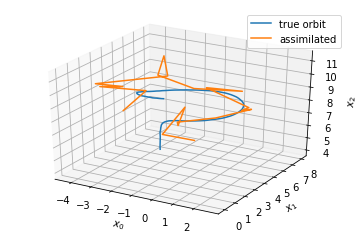

Before assimilation
cost 2083.23467905


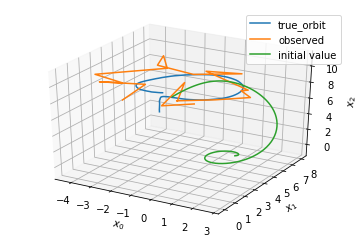

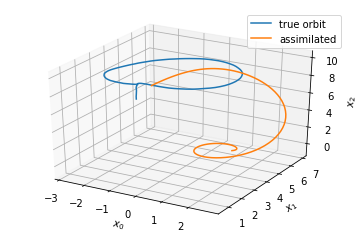

      fun: 49.841275799327136
 hess_inv: <707x707 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.36759083e-01,   1.14905792e-02,  -5.64331224e-02,
        -1.07803063e-01,  -8.83083063e-02,  -1.36912054e-01,
        -6.48391483e-02,  -9.78962084e-02,   1.49297378e-02,
        -6.36407402e-02,  -5.66152243e-02,   2.28004440e-01,
         1.80258640e-02,   2.07423535e-02,  -9.19389682e-02,
         2.25067394e-02,  -6.31794489e-02,  -4.82683712e-02,
         2.07889691e-01,   1.20405714e-02,   1.77086797e-02,
        -8.65435924e-02,   3.07116928e-02,  -6.18031967e-02,
        -4.14849928e-02,   1.87517848e-01,   6.79027205e-03,
         1.32461293e-02,  -8.15815346e-02,   3.94484720e-02,
        -5.95868903e-02,  -3.63875932e-02,   1.67161234e-01,
         1.90812844e-03,   7.47339967e-03,  -7.69329408e-02,
         4.85763068e-02,  -5.65899751e-02,  -3.30821504e-02,
         1.47076015e-01,  -2.96828493e-03,   5.35940011e-04,
        -9.13560806e-02,   4.08671423e-02,  -

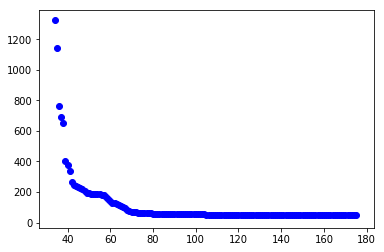

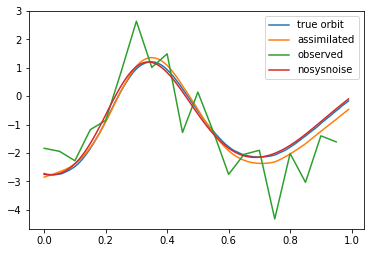

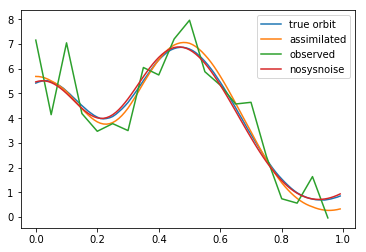

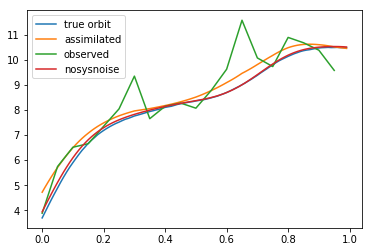

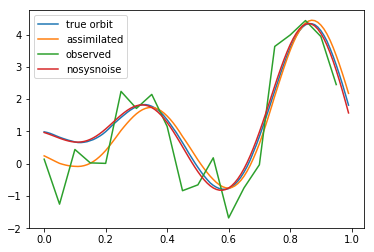

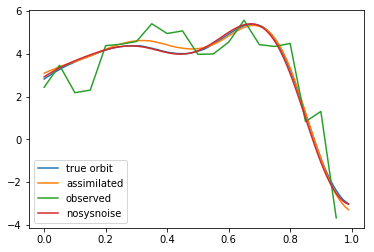

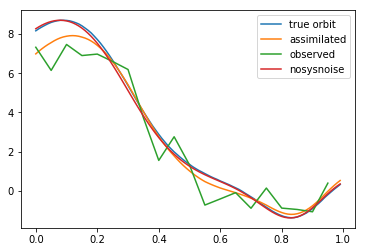

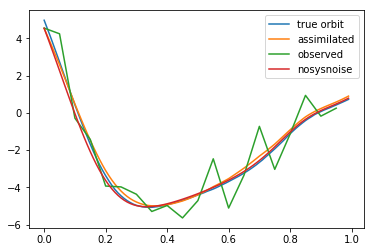

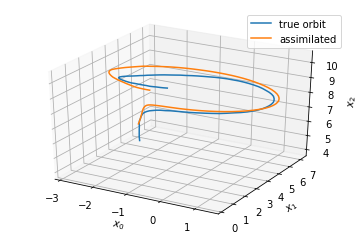

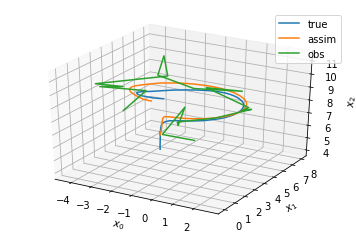

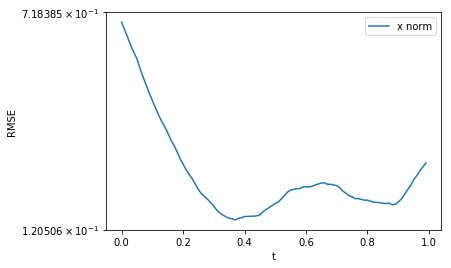

RMSE:  0.193373675692
4DVar optimal cost:  49.8412757993
true cost:  58.783210153


In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 14 17:01:40 2017

@author: yk
"""

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import math

def handler(func, *args):
    return func(*args)

#%%
class Lorenz96:
    def __init__(self, N, F):
        self.N = N
        self.F = F
    def gradient(self, x):
        d = np.zeros(self.N)
        d[0] = (x[1] - x[self.N-2]) * x[self.N-1] - x[0]
        d[1] = (x[2] - x[self.N-1]) * x[0]- x[1]
        d[self.N-1] = (x[0] - x[self.N-3]) * x[self.N-2] - x[self.N-1]
        for i in range(2, self.N-1):
            d[i] = (x[i+1] - x[i-2]) * x[i-1] - x[i]
        return d + self.F
        
    def gradient_adjoint(self, la, x):
        mt = np.zeros((self.N,self.N))
        for i in range(self.N):
            for j in range(self.N):
                if (((i-1) % self.N) == (j % self.N)):
                    mt[j][i] += x[(i+1) % self.N] - x[(i-2) % self.N]
                if (((i+1) % self.N) == (j % self.N)):
                    mt[j][i] += x[(i-1) % self.N]
                if (((i-2) % self.N) == (j % self.N)):
                    mt[j][i] -= x[(i-1) % self.N]
                if ((i     % self.N) == (j % self.N)):
                    mt[j][i] -= 1
        gr = mt @ la
        return gr

class Adjoint:
    def __init__(self, dx, dla, N, T, dt, it, x, y, q):
        self.dx = dx
        self.dla = dla
        self.N = N
        self.T = T
        self.dt = dt
        self.x = x
        self.y = y
        self.q = q
        self.it = it
        self.minute_steps = int(T/self.dt)
        self.steps = int(self.minute_steps/it)
        
    def orbit(self):
        for i in range(self.minute_steps-1):
            k1 = handler(self.dx, self.x[i]                )
            k2 = handler(self.dx, self.x[i] + k1*self.dt/2.)
            k3 = handler(self.dx, self.x[i] + k2*self.dt/2.)
            k4 = handler(self.dx, self.x[i] + k3*self.dt   )
            self.x[i+1] = self.x[i] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6 + self.q[i] # discrete system noise is added
        return self.x
    
    def observed(self, stddev):
        self.orbit()
        for i in range(self.steps):
            for j in range(self.N):
                self.x[i,j] += stddev * np.random.randn() # fixed
        return self.x

    def true_observed(self, stddev):
        tob = np.copy(self.orbit())
        for i in range(self.steps):
            for j in range(self.N):
                self.x[i,j] += stddev * np.random.randn() # fixed
        return tob, self.x
    
    def calc_la(self, la):
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                if (n < self.it*self.steps - 1):
                    p1 = handler(self.dx, self.x[n]                )
                    p2 = handler(self.dx, self.x[n] + p1*self.dt/2.)
                    p3 = handler(self.dx, self.x[n] + p2*self.dt/2.)
                    p4 = handler(self.dx, self.x[n] + p3*self.dt   )
                    gr = (p1 + 2*p2 + 2*p3 + p4)/6
    
                    k1 = handler(self.dla, la[n+1], self.x[n] + gr*self.dt)
                    k2 = handler(self.dla, la[n+1] - k1*self.dt/2, self.x[n] + gr*self.dt/2)
                    k3 = handler(self.dla, la[n+1] - k2*self.dt/2, self.x[n] + gr*self.dt/2)
                    k4 = handler(self.dla, la[n+1] - k3*self.dt, self.x[n])
                    la[n] = la[n+1] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
            la[self.it*i] += self.x[self.it*i] - self.y[i]
        return la

    def gradient_from_x0(self, x0_q):
        self.x[0] = x0_q[:self.N]
        for i in range(self.minute_steps):
            self.q[i] = x0_q[self.N*(i+1) : self.N*(i+2)]
        self.orbit()
        la = np.zeros((self.minute_steps + 1, self.N))
        self.calc_la(la)
        
        gr = np.zeros(self.N * (self.minute_steps + 1))
        gr[:self.N] = la[0]
        for n in range(self.minute_steps):
            gr[self.N*(n+1) : self.N*(n+2)] = la[n+1] + 100. * self.q[n]        
        return gr
    
    def cost(self, x0_q):
        self.x[0] = x0_q[:self.N]
        for i in range(self.minute_steps):
            self.q[i] = x0_q[self.N*(i+1) : self.N*(i+2)]
        self.orbit()
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for n in range(self.minute_steps):
            cost += 100. * self.q[n] @ self.q[n]
        for i in range(self.steps):
#            print ((self.x[self.it*i] - self.y[i]) @ (self.x[self.it*i] - self.y[i]))
            cost += (self.x[self.it*i] - self.y[i]) @ (self.x[self.it*i] - self.y[i])
        return cost/2.0 # fixed
    
    def true_cost(self):
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps):
            cost += (self.x[self.it*i][0:self.N] - self.y[i]) @ (self.x[self.it*i][0:self.N] - self.y[i])
        return cost/2.0 # fixed
    
    def numerical_gradient_from_x0(self, x0_q, h):
        gr = np.zeros(self.N * (self.minute_steps + 1))
        c1 = self.cost(x0_q)
        for j in range(N * (self.minute_steps + 1)):
            xx = np.copy(x0_q)
            xx[j] += h
            c = self.cost(xx)
            gr[j] = (c - c1)/h        
        return gr

    def cbf(self, x0):
        global count
        count += 1
        plt.scatter(count, self.cost(x0), c='b')
    
#%%
def plot_orbit(dat):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat[:,0],dat[:,1],dat[:,2])
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.show()

def compare_orbit(dat1, dat2):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label='true orbit')
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label='assimilated')
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

def compare_orbit3(dat1, dat2, dat3, label1, label2, label3):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label=label1)
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label=label2)
    ax.plot(dat3[:,0],dat3[:,1],dat3[:,2],label=label3)
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

    
#%%
from scipy.optimize import minimize

N = 7
#pref = "data/" + str(N) + "/"
pref = "/Users/konta/bitbucket/androsace/dacamp/task1/lorenz_sysnoise_data/" + str(N) + "/"

F = 8
year = 0.01


day = 365 * year
dt = 0.01

# T = day * 0.2
T = 1.0
print("T", T)
print("day", T/0.2)
it = 5
minute_steps = int(T/dt)
steps = int(minute_steps/it)

stddev = 1

lorenz = Lorenz96(N, F)

tob = np.loadtxt(pref + "year.1.dat")

nosysnoise = np.loadtxt(pref + "nosysnoise.1.dat")

obs = np.loadtxt(pref + "observed." + str(it) + ".1.dat")

compare_orbit(tob[0:minute_steps], obs[0:steps])

t = np.arange(0., T, dt)
t_it = np.arange(0., T, dt*it)

x_q_opt = np.zeros(N * (minute_steps + 1))
x_q_opt[:N] = np.loadtxt(pref + "assimilation_xzero.2.dat")

x = np.zeros((minute_steps, N))
q = np.zeros((minute_steps, N))
scheme = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, N, T, dt, it, x, obs, q)


print("Before assimilation")
print("cost", scheme.cost(x_q_opt))
compare_orbit3(tob[0:minute_steps], obs[0:steps], scheme.x, 'true_orbit', 'observed', 'initial value')
compare_orbit(tob[0:minute_steps], scheme.x)
#
#print("Analytical and numerical gradient comparison")
#gr_anal = scheme.gradient_from_x0(x_q_opt)
#print ("gr_anal", "%f\t"*N*(minute_steps+1) % tuple(gr_anal))
#gr_num = scheme.numerical_gradient_from_x0(x_q_opt, 0.001)
#print ("gr_num", "%f\t"*N*(minute_steps+1) % tuple(gr_num))
#print ("relative error", "%f\t"*N*(minute_steps+1) % tuple((gr_anal - gr_num)/gr_num))
#
#print("variable")
#for i in range(N):
#    print ("%e\t%e\t%e" % (gr_anal[i], gr_num[i], ((gr_anal - gr_num)/gr_num)[i]))
#print("")
#print("sysnoise")
#for i in range(N, N*(minute_steps+1)):
#    print ("%e\t%e\t%e" % (gr_anal[i], gr_num[i], ((gr_anal - gr_num)/gr_num)[i]))

#%%
fig = plt.figure()
res = minimize(scheme.cost, x_q_opt, jac=scheme.gradient_from_x0, method='L-BFGS-B', callback=scheme.cbf)
print (res)
print ("true x0", tob[0])

#%%
#for j in range(3):
for j in range(N):
    fig = plt.figure()
    plt.plot(t, tob[0:minute_steps,j], label='true orbit')
    plt.plot(t, scheme.x[0:minute_steps,j], label='assimilated')
    plt.plot(t_it, obs[0:steps,j], label='observed')
    plt.plot(t, nosysnoise[0:minute_steps,j], label='nosysnoise')
    plt.legend()
    plt.show()

compare_orbit(tob[0:minute_steps], scheme.x)
compare_orbit3(tob[0:minute_steps], scheme.x, obs[0:steps], 'true', 'assim', 'obs')

#%%
fig = plt.figure()
plt.plot(t, [np.linalg.norm(scheme.x[i] - tob[i])/math.sqrt(N) for i in range(len(t))], label='x norm')
plt.xlabel('t')
plt.ylabel('RMSE')
plt.yscale('symlog')
plt.legend()
plt.show()

print ("RMSE: ", np.mean([np.linalg.norm(scheme.x[i] - tob[i])/math.sqrt(N) for i in range(int(len(t)*0.4),int(len(t)*0.6))]))

print('4DVar optimal cost: ', res.fun)
q2 = np.zeros(N * (steps + 1))
scheme_true = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, N, T, dt, it, tob, obs, q2)
print('true cost: ', scheme_true.true_cost())


## 弱拘束4D-Var（time-sparseなシステムノイズを許した場合）

T 2.0
day 10.0


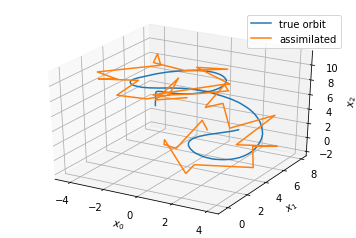

Before assimilation
cost 4166.68694462


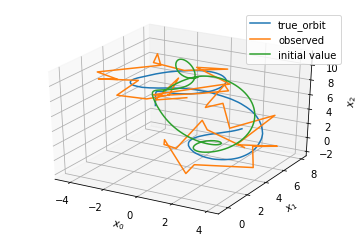

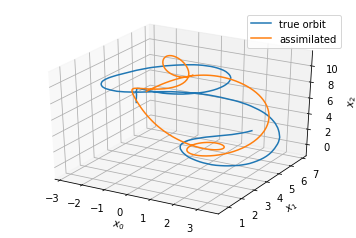

true x0 [-2.718911  5.419507  3.693462  0.986995  2.82212   8.168231  4.972515]


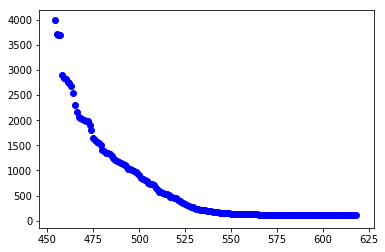

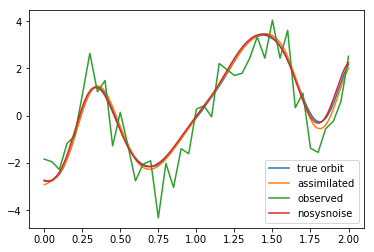

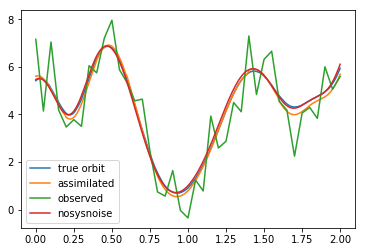

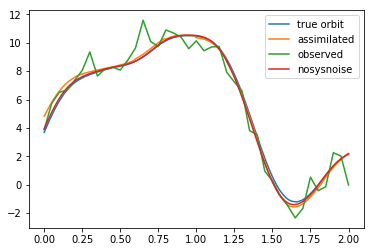

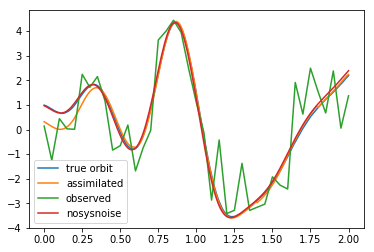

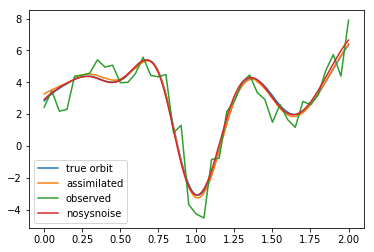

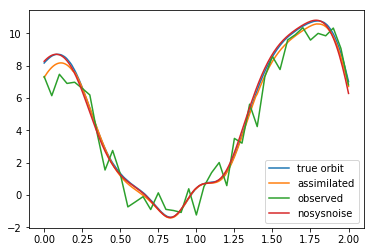

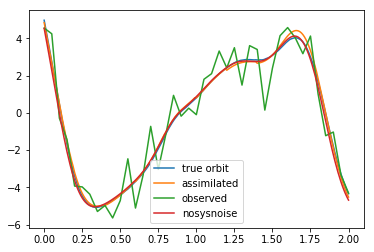

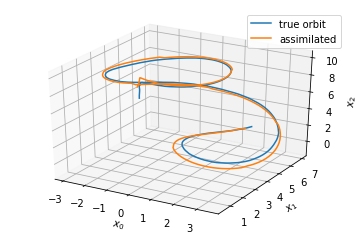

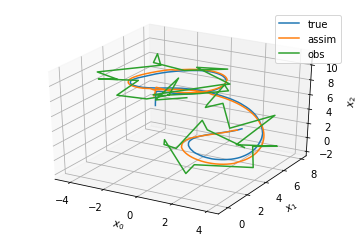

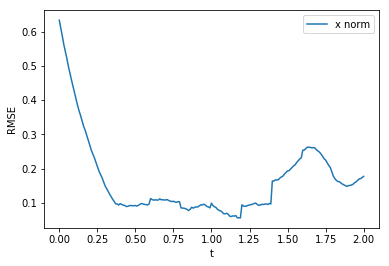

RMSE:  0.0788665527103
4DVar optimal cost:  115.955312851
true cost:  598.144827269


In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 14 17:01:40 2017

@author: yk
"""

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import math

def handler(func, *args):
    return func(*args)

#%%
class Lorenz96:
    def __init__(self, N, F):
        self.N = N
        self.F = F
    def gradient(self, x):
        d = np.zeros(self.N)
        d[0] = (x[1] - x[self.N-2]) * x[self.N-1] - x[0]
        d[1] = (x[2] - x[self.N-1]) * x[0]- x[1]
        d[self.N-1] = (x[0] - x[self.N-3]) * x[self.N-2] - x[self.N-1]
        for i in range(2, self.N-1):
            d[i] = (x[i+1] - x[i-2]) * x[i-1] - x[i]
        return d + self.F
        
    def gradient_adjoint(self, la, x):
        mt = np.zeros((self.N,self.N))
        for i in range(self.N):
            for j in range(self.N):
                if (((i-1) % self.N) == (j % self.N)):
                    mt[j][i] += x[(i+1) % self.N] - x[(i-2) % self.N]
                if (((i+1) % self.N) == (j % self.N)):
                    mt[j][i] += x[(i-1) % self.N]
                if (((i-2) % self.N) == (j % self.N)):
                    mt[j][i] -= x[(i-1) % self.N]
                if ((i     % self.N) == (j % self.N)):
                    mt[j][i] -= 1
        gr = mt @ la
        return gr

class Adjoint:
    def __init__(self, dx, dla, N, T, dt, it, sysnoise_it, sysnoise_variance, x, y, q):
        self.dx = dx
        self.dla = dla
        self.N = N
        self.T = T
        self.dt = dt
        self.x = x
        self.y = y
        self.q = q
        self.it = it
        self.minute_steps = int(T/self.dt)
        self.steps = int(self.minute_steps/it)
        self.sysnoise_it = sysnoise_it
        self.sysnoise_steps = int(self.minute_steps/sysnoise_it)
        self.sysnoise_variance = sysnoise_variance
        
    def orbit(self):
        for i in range(self.sysnoise_steps):
            for j in range(self.sysnoise_it):
                n = self.sysnoise_it*i + j
                k1 = handler(self.dx, self.x[n]                )
                k2 = handler(self.dx, self.x[n] + k1*self.dt/2.)
                k3 = handler(self.dx, self.x[n] + k2*self.dt/2.)
                k4 = handler(self.dx, self.x[n] + k3*self.dt   )
                self.x[n+1] = self.x[n] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
            self.x[self.sysnoise_it*(i+1)] += self.q[i+1]
        return self.x
    
    def observed(self, stddev):
        self.orbit()
        for i in range(self.steps + 1):
            for j in range(self.N):
                self.x[i,j] += stddev * np.random.randn() # fixed
        return self.x

    def true_observed(self, stddev):
        tob = np.copy(self.orbit())
        for i in range(self.steps + 1):
            for j in range(self.N):
                self.x[i,j] += stddev * np.random.randn() # fixed
        return tob, self.x
    
    def calc_la(self, la):
        la[self.minute_steps] = self.x[self.minute_steps] - self.y[self.steps]
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j

                p1 = handler(self.dx, self.x[n]                )
                p2 = handler(self.dx, self.x[n] + p1*self.dt/2.)
                p3 = handler(self.dx, self.x[n] + p2*self.dt/2.)
                p4 = handler(self.dx, self.x[n] + p3*self.dt   )
                gr = (p1 + 2*p2 + 2*p3 + p4)/6
    
                k1 = handler(self.dla, la[n+1], self.x[n] + gr*self.dt)
                k2 = handler(self.dla, la[n+1] - k1*self.dt/2, self.x[n] + gr*self.dt/2)
                k3 = handler(self.dla, la[n+1] - k2*self.dt/2, self.x[n] + gr*self.dt/2)
                k4 = handler(self.dla, la[n+1] - k3*self.dt, self.x[n])
                la[n] = la[n+1] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
            la[self.it*i] += self.x[self.it*i] - self.y[i]
        return la

    def gradient_from_x0(self, x0_q):
        self.x[0] = x0_q[:self.N]
        for i in range(self.sysnoise_steps):
            self.q[i+1] = x0_q[self.N*(i+1) : self.N*(i+2)]
        self.orbit()
        la = np.zeros((self.minute_steps + 1, self.N))
        self.calc_la(la)
        
        gr = np.zeros(self.N * (self.sysnoise_steps + 1))
        gr[:self.N] = la[0]
        for i in range(self.sysnoise_steps):
            gr[self.N*(i+1) : self.N*(i+2)] = la[self.sysnoise_it*(i+1)] + self.q[i+1]/self.sysnoise_variance # fix me! discrete equation suit in this case?
        return gr
    
    def cost(self, x0_q):
        self.x[0] = x0_q[:self.N]
        for i in range(self.sysnoise_steps):
            self.q[i+1] = x0_q[self.N*(i+1) : self.N*(i+2)]
        self.orbit()
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.sysnoise_steps):
            cost += self.q[i+1] @ self.q[i+1] / self.sysnoise_variance
        for i in range(self.steps + 1):
#            print ((self.x[self.it*i] - self.y[i]) @ (self.x[self.it*i] - self.y[i]))
            cost += (self.x[self.it*i] - self.y[i]) @ (self.x[self.it*i] - self.y[i])
        return cost/2.0 # fixed
    
    def true_cost(self):
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps + 1):
            cost += (self.x[self.it*i][0:self.N] - self.y[i]) @ (self.x[self.it*i][0:self.N] - self.y[i])
        return cost/2.0 # fixed
    
    def numerical_gradient_from_x0(self, x0_q, h):
        gr = np.zeros(self.N * (self.minute_steps + 1))
        c1 = self.cost(x0_q)
        for j in range(self.N * (self.minute_steps + 1)):
            xx = np.copy(x0_q)
            xx[j] += h
            c = self.cost(xx)
            gr[j] = (c - c1)/h        
        return gr

    def cbf(self, x0):
        global count
        count += 1
        plt.scatter(count, self.cost(x0), c='b')
    
#%%
def plot_orbit(dat):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat[:,0],dat[:,1],dat[:,2])
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.show()

def compare_orbit(dat1, dat2):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label='true orbit')
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label='assimilated')
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

def compare_orbit3(dat1, dat2, dat3, label1, label2, label3):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label=label1)
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label=label2)
    ax.plot(dat3[:,0],dat3[:,1],dat3[:,2],label=label3)
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

    
#%%
from scipy.optimize import minimize

N = 7
#pref = "data/" + str(N) + "/"
pref = "/Users/konta/bitbucket/androsace/dacamp/task1/lorenz_sysnoise_data/" + str(N) + "/"

F = 8
year = 0.01


day = 365 * year
dt = 0.01

# T = day * 0.2
T = 2.0
print("T", T)
print("day", T/0.2)
it = 5
minute_steps = int(T/dt)
steps = int(minute_steps/it)

sysnoise_it = 20
sysnoise_steps = int(minute_steps/sysnoise_it)
sysnoise_variance = 0.04

stddev = 1

lorenz = Lorenz96(N, F)

tob = np.loadtxt(pref + "year.1.dat")

nosysnoise = np.loadtxt(pref + "nosysnoise.1.dat")

obs = np.loadtxt(pref + "observed." + str(it) + ".1.dat")

compare_orbit(tob[0:minute_steps], obs[0:steps])

t = np.arange(0., T, dt)
t_it = np.arange(0., T, dt*it)

t_plus_1 = np.arange(0., T+dt, dt)
t_it_plus_1 = np.arange(0., T+dt, dt*it)

x_q_opt = np.zeros(N * (sysnoise_steps + 1))
x_q_opt[:N] = np.loadtxt(pref + "assimilation_xzero.2.dat")

x = np.zeros((minute_steps + 1, N))
q = np.zeros((sysnoise_steps + 1, N))
scheme = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, N, T, dt, it, sysnoise_it, sysnoise_variance, x, obs, q)

print("Before assimilation")
print("cost", scheme.cost(x_q_opt))
compare_orbit3(tob[0:minute_steps+1], obs[0:steps+1], scheme.x, 'true_orbit', 'observed', 'initial value')
compare_orbit(tob[0:minute_steps+1], scheme.x)

#print("Analytical and numerical gradient comparison")
#gr_anal = scheme.gradient_from_x0(x_q_opt)
#print ("gr_anal", "%f\t"*N*(minute_steps+1) % tuple(gr_anal))
#gr_num = scheme.numerical_gradient_from_x0(x_q_opt, 0.001)
#print ("gr_num", "%f\t"*N*(minute_steps+1) % tuple(gr_num))
#print ("relative error", "%f\t"*N*(minute_steps+1) % tuple((gr_anal - gr_num)/gr_num))
#
#print("variable")
#for i in range(N):
#    print ("%e\t%e\t%e" % (gr_anal[i], gr_num[i], ((gr_anal - gr_num)/gr_num)[i]))
#print("")
#print("sysnoise")
#for i in range(N, N*(minute_steps+1)):
#    print ("%e\t%e\t%e" % (gr_anal[i], gr_num[i], ((gr_anal - gr_num)/gr_num)[i]))

#%%
fig = plt.figure()
res = minimize(scheme.cost, x_q_opt, jac=scheme.gradient_from_x0, method='L-BFGS-B', callback=scheme.cbf)
#print (res)
print ("true x0", tob[0])

#%%
#for j in range(3):
for j in range(N):
    fig = plt.figure()
    plt.plot(t_plus_1, tob[0:minute_steps+1,j], label='true orbit')
    plt.plot(t_plus_1, scheme.x[0:minute_steps+1,j], label='assimilated')
    plt.plot(t_it_plus_1, obs[0:steps+1,j], label='observed')
    plt.plot(t_plus_1, nosysnoise[0:minute_steps+1,j], label='nosysnoise')
    plt.legend()
    plt.show()

compare_orbit(tob[0:minute_steps+1], scheme.x)
compare_orbit3(tob[0:minute_steps+1], scheme.x, obs[0:steps+1], 'true', 'assim', 'obs')

#%%
fig = plt.figure()
plt.plot(t_plus_1, [np.linalg.norm(scheme.x[i] - tob[i])/math.sqrt(N) for i in range(len(t_plus_1))], label='x norm')
plt.xlabel('t')
plt.ylabel('RMSE')
#plt.yscale('symlog')
plt.legend()
plt.show()

print ("RMSE: ", np.mean([np.linalg.norm(scheme.x[i] - tob[i])/math.sqrt(N) for i in range(int(len(t_plus_1)*0.4),int(len(t_plus_1)*0.6))]))

print('4DVar optimal cost: ', res.fun)
q2 = np.zeros(N * (steps + 1))
scheme_true = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, N, T, dt, sysnoise_it, it, sysnoise_variance, tob, obs, q2)
print('true cost: ', scheme_true.true_cost())


・システムノイズがあっても、またカオスな対象に対して比較的長い同化期間をとっても、同化可能だが、システムノイズに対するcostをうまくチューニングしないと破綻する。

T 2.0
day 10.0


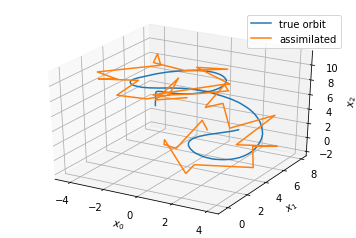

Before assimilation
cost 3294.77862397


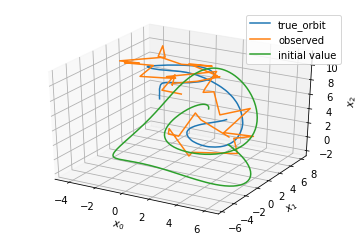

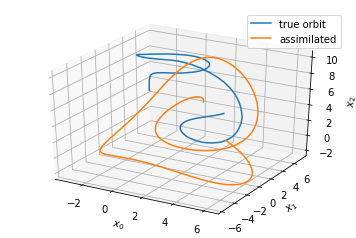

true x0 [-2.718911  5.419507  3.693462  0.986995  2.82212   8.168231  4.972515]


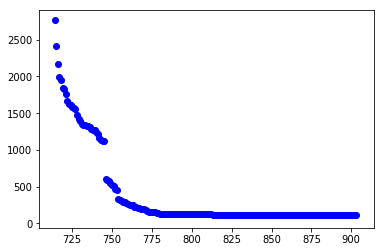

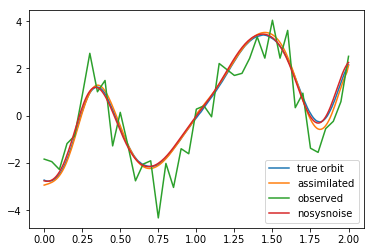

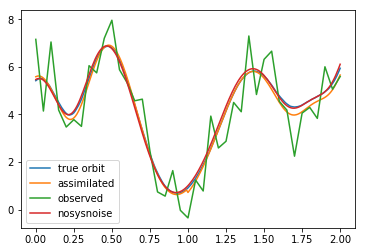

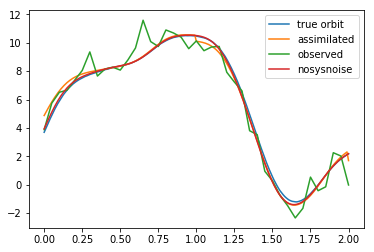

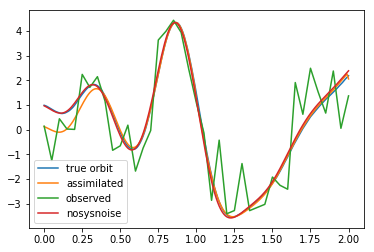

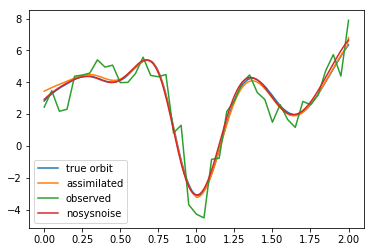

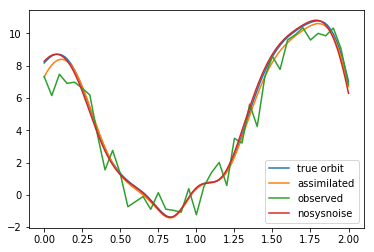

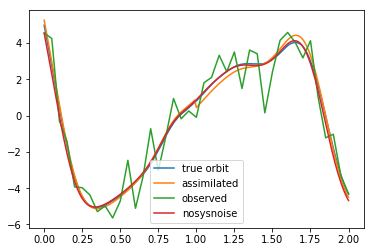

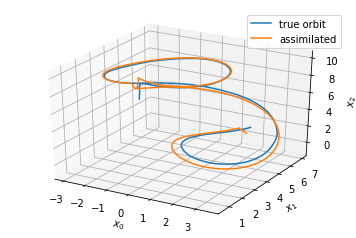

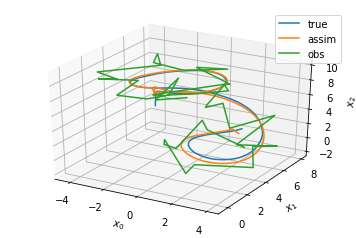

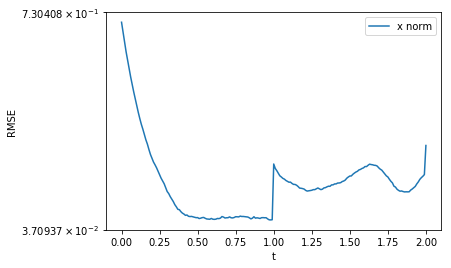

RMSE:  0.13516966912
4DVar optimal cost:  116.543191862
true cost:  106.647535289


In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 14 17:01:40 2017

@author: yk
"""

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import math

def handler(func, *args):
    return func(*args)

#%%
class Lorenz96:
    def __init__(self, N, F):
        self.N = N
        self.F = F
    def gradient(self, x):
        d = np.zeros(self.N)
        d[0] = (x[1] - x[self.N-2]) * x[self.N-1] - x[0]
        d[1] = (x[2] - x[self.N-1]) * x[0]- x[1]
        d[self.N-1] = (x[0] - x[self.N-3]) * x[self.N-2] - x[self.N-1]
        for i in range(2, self.N-1):
            d[i] = (x[i+1] - x[i-2]) * x[i-1] - x[i]
        return d + self.F
        
    def gradient_adjoint(self, la, x):
        mt = np.zeros((self.N,self.N))
        for i in range(self.N):
            for j in range(self.N):
                if (((i-1) % self.N) == (j % self.N)):
                    mt[j][i] += x[(i+1) % self.N] - x[(i-2) % self.N]
                if (((i+1) % self.N) == (j % self.N)):
                    mt[j][i] += x[(i-1) % self.N]
                if (((i-2) % self.N) == (j % self.N)):
                    mt[j][i] -= x[(i-1) % self.N]
                if ((i     % self.N) == (j % self.N)):
                    mt[j][i] -= 1
        gr = mt @ la
        return gr

class Adjoint:
    def __init__(self, dx, dla, N, T, dt, it, sysnoise_it, sysnoise_variance, x, y, q):
        self.dx = dx
        self.dla = dla
        self.N = N
        self.T = T
        self.dt = dt
        self.x = x
        self.y = y
        self.q = q
        self.it = it
        self.minute_steps = int(T/self.dt)
        self.steps = int(self.minute_steps/it)
        self.sysnoise_it = sysnoise_it
        self.sysnoise_steps = int(self.minute_steps/sysnoise_it)
        self.sysnoise_variance = sysnoise_variance
        
    def orbit(self):
        for i in range(self.sysnoise_steps):
            for j in range(self.sysnoise_it):
                n = self.sysnoise_it*i + j
                k1 = handler(self.dx, self.x[n]                )
                k2 = handler(self.dx, self.x[n] + k1*self.dt/2.)
                k3 = handler(self.dx, self.x[n] + k2*self.dt/2.)
                k4 = handler(self.dx, self.x[n] + k3*self.dt   )
                self.x[n+1] = self.x[n] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
            self.x[self.sysnoise_it*(i+1)] += self.q[i+1]
        return self.x
    
    def observed(self, stddev):
        self.orbit()
        for i in range(self.steps + 1):
            for j in range(self.N):
                self.x[i,j] += stddev * np.random.randn() # fixed
        return self.x

    def true_observed(self, stddev):
        tob = np.copy(self.orbit())
        for i in range(self.steps + 1):
            for j in range(self.N):
                self.x[i,j] += stddev * np.random.randn() # fixed
        return tob, self.x
    
    def calc_la(self, la):
        la[self.minute_steps] = self.x[self.minute_steps] - self.y[self.steps]
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j

                p1 = handler(self.dx, self.x[n]                )
                p2 = handler(self.dx, self.x[n] + p1*self.dt/2.)
                p3 = handler(self.dx, self.x[n] + p2*self.dt/2.)
                p4 = handler(self.dx, self.x[n] + p3*self.dt   )
                gr = (p1 + 2*p2 + 2*p3 + p4)/6
    
                k1 = handler(self.dla, la[n+1], self.x[n] + gr*self.dt)
                k2 = handler(self.dla, la[n+1] - k1*self.dt/2, self.x[n] + gr*self.dt/2)
                k3 = handler(self.dla, la[n+1] - k2*self.dt/2, self.x[n] + gr*self.dt/2)
                k4 = handler(self.dla, la[n+1] - k3*self.dt, self.x[n])
                la[n] = la[n+1] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
            la[self.it*i] += self.x[self.it*i] - self.y[i]
        return la

    def gradient_from_x0(self, x0_q):
        self.x[0] = x0_q[:self.N]
        for i in range(self.sysnoise_steps):
            self.q[i+1] = x0_q[self.N*(i+1) : self.N*(i+2)]
        self.orbit()
        la = np.zeros((self.minute_steps + 1, self.N))
        self.calc_la(la)
        
        gr = np.zeros(self.N * (self.sysnoise_steps + 1))
        gr[:self.N] = la[0]
        for i in range(self.sysnoise_steps):
            gr[self.N*(i+1) : self.N*(i+2)] = la[self.sysnoise_it*(i+1)] + self.q[i+1]/self.sysnoise_variance # fix me! discrete equation suit in this case?
        return gr
    
    def cost(self, x0_q):
        self.x[0] = x0_q[:self.N]
        for i in range(self.sysnoise_steps):
            self.q[i+1] = x0_q[self.N*(i+1) : self.N*(i+2)]
        self.orbit()
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.sysnoise_steps):
            cost += self.q[i+1] @ self.q[i+1] / self.sysnoise_variance
        for i in range(self.steps + 1):
#            print ((self.x[self.it*i] - self.y[i]) @ (self.x[self.it*i] - self.y[i]))
            cost += (self.x[self.it*i] - self.y[i]) @ (self.x[self.it*i] - self.y[i])
        return cost/2.0 # fixed
    
    def true_cost(self):
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps + 1):
            cost += (self.x[self.it*i][0:self.N] - self.y[i]) @ (self.x[self.it*i][0:self.N] - self.y[i])
        return cost/2.0 # fixed
    
    def numerical_gradient_from_x0(self, x0_q, h):
        gr = np.zeros(self.N * (self.sysnoise_steps + 1))
        c1 = self.cost(x0_q)
        for j in range(self.N * (self.sysnoise_steps + 1)):
            xx = np.copy(x0_q)
            xx[j] += h
            c = self.cost(xx)
            gr[j] = (c - c1)/h        
        return gr

    def cbf(self, x0):
        global count
        count += 1
        plt.scatter(count, self.cost(x0), c='b')
    
#%%
def plot_orbit(dat):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat[:,0],dat[:,1],dat[:,2])
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.show()

def compare_orbit(dat1, dat2):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label='true orbit')
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label='assimilated')
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

def compare_orbit3(dat1, dat2, dat3, label1, label2, label3):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label=label1)
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label=label2)
    ax.plot(dat3[:,0],dat3[:,1],dat3[:,2],label=label3)
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

    
#%%
from scipy.optimize import minimize

N = 7
#pref = "data/" + str(N) + "/"
pref = "/Users/konta/bitbucket/androsace/dacamp/task1/lorenz_sysnoise_data/" + str(N) + "/"

F = 8
year = 0.01


day = 365 * year
dt = 0.01

# T = day * 0.2
T = 2.0
print("T", T)
print("day", T/0.2)
it = 5
minute_steps = int(T/dt)
steps = int(minute_steps/it)

sysnoise_it = 100
sysnoise_steps = int(minute_steps/sysnoise_it)
sysnoise_variance = 0.4

stddev = 1

lorenz = Lorenz96(N, F)

tob = np.loadtxt(pref + "year.1.dat")

nosysnoise = np.loadtxt(pref + "nosysnoise.1.dat")

obs = np.loadtxt(pref + "observed." + str(it) + ".1.dat")

compare_orbit(tob[0:minute_steps], obs[0:steps])

t = np.arange(0., T, dt)
t_it = np.arange(0., T, dt*it)

t_plus_1 = np.arange(0., T+dt, dt)
t_it_plus_1 = np.arange(0., T+dt, dt*it)

x_q_opt = np.zeros(N * (sysnoise_steps + 1))
x_q_opt[:N] = np.loadtxt(pref + "year.2.dat")[np.random.randint(len(tob))]

x = np.zeros((minute_steps + 1, N))
q = np.zeros((sysnoise_steps + 1, N))
scheme = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, N, T, dt, it, sysnoise_it, sysnoise_variance, x, obs, q)

print("Before assimilation")
print("cost", scheme.cost(x_q_opt))
compare_orbit3(tob[0:minute_steps+1], obs[0:steps+1], scheme.x, 'true_orbit', 'observed', 'initial value')
compare_orbit(tob[0:minute_steps+1], scheme.x)

#print("Analytical and numerical gradient comparison")
#gr_anal = scheme.gradient_from_x0(x_q_opt)
#print ("gr_anal", "%f\t"*N*(sysnoise_steps+1) % tuple(gr_anal))
#gr_num = scheme.numerical_gradient_from_x0(x_q_opt, 0.001)
#print ("gr_num", "%f\t"*N*(sysnoise_steps+1) % tuple(gr_num))
#print ("relative error", "%f\t"*N*(sysnoise_steps+1) % tuple((gr_anal - gr_num)/gr_num))
#
#print("variable")
#for i in range(N):
#    print ("%e\t%e\t%e" % (gr_anal[i], gr_num[i], ((gr_anal - gr_num)/gr_num)[i]))
#print("")
#print("sysnoise")
#for i in range(N, N*(minute_steps+1)):
#    print ("%e\t%e\t%e" % (gr_anal[i], gr_num[i], ((gr_anal - gr_num)/gr_num)[i]))

#%%
fig = plt.figure()
res = minimize(scheme.cost, x_q_opt, jac=scheme.gradient_from_x0, method='L-BFGS-B', callback=scheme.cbf)
#print (res)
print ("true x0", tob[0])

#%%
#for j in range(3):
for j in range(N):
    fig = plt.figure()
    plt.plot(t_plus_1, tob[0:minute_steps+1,j], label='true orbit')
    plt.plot(t_plus_1, scheme.x[0:minute_steps+1,j], label='assimilated')
    plt.plot(t_it_plus_1, obs[0:steps+1,j], label='observed')
    plt.plot(t_plus_1, nosysnoise[0:minute_steps+1,j], label='nosysnoise')
    plt.legend()
    plt.show()

compare_orbit(tob[0:minute_steps+1], scheme.x)
compare_orbit3(tob[0:minute_steps+1], scheme.x, obs[0:steps+1], 'true', 'assim', 'obs')

#%%
fig = plt.figure()
plt.plot(t_plus_1, [np.linalg.norm(scheme.x[i] - tob[i])/math.sqrt(N) for i in range(len(t_plus_1))], label='x norm')
plt.xlabel('t')
plt.ylabel('RMSE')
plt.yscale('symlog')
plt.legend()
plt.show()

print ("RMSE: ", np.mean([np.linalg.norm(scheme.x[i] - tob[i])/math.sqrt(N) for i in range(int(len(t_plus_1)*0.4),int(len(t_plus_1)*0.6))]))

print('4DVar optimal cost: ', res.fun)
q2 = np.zeros(N * (steps + 1))
scheme_true = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, N, T, dt, sysnoise_it, it, sysnoise_variance, tob, obs, q2)
print('true cost: ', scheme_true.true_cost())


## 毎時刻システムノイズを許すが、各々のwindow内では同じシステムノイズにして最適化の次元を削減した場合 (Yannick論文のsection4の方法)

T 2.0
day 10.0


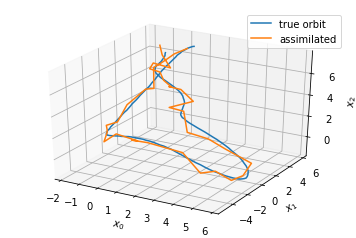

Before assimilation
cost 32743.2425845


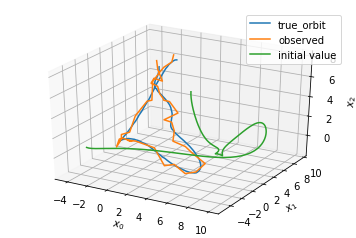

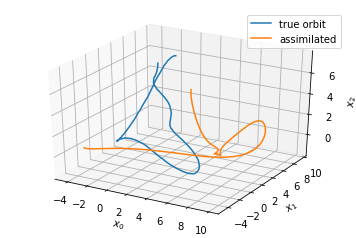

true x0 [-0.089869  3.1916    7.186459 -4.270852  1.727789  5.29329   5.155666]


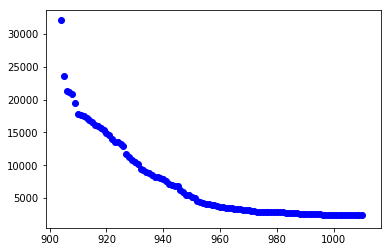

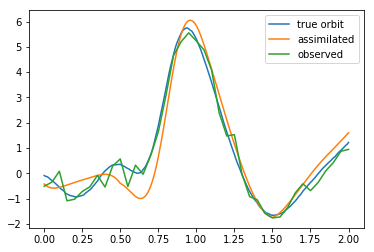

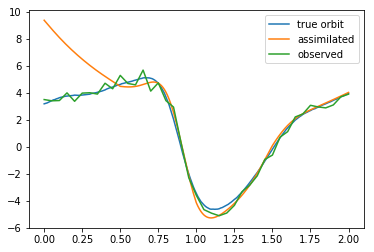

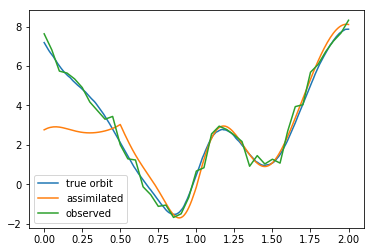

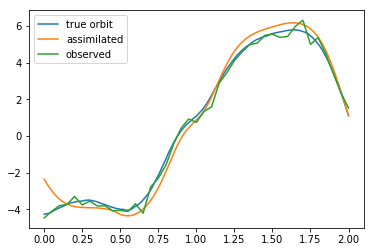

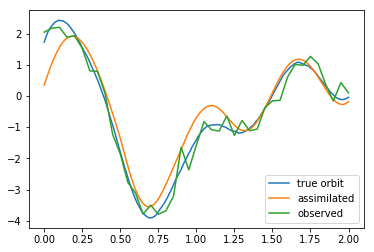

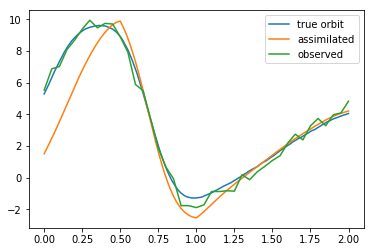

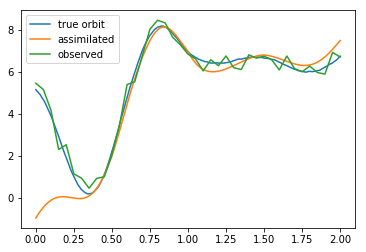

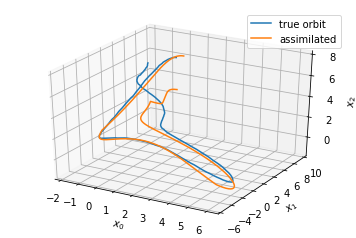

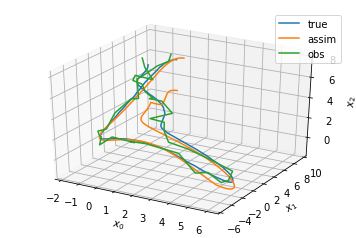

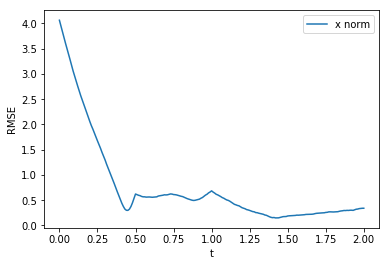

RMSE:  0.534638828747
4DVar optimal cost:  2439.62670047
true cost:  2691.41176944


In [10]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 14 17:01:40 2017

@author: yk
"""

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import math

def handler(func, *args):
    return func(*args)

#%%
class Lorenz96:
    def __init__(self, N, F):
        self.N = N
        self.F = F
    def gradient(self, x):
        d = np.zeros(self.N)
        d[0] = (x[1] - x[self.N-2]) * x[self.N-1] - x[0]
        d[1] = (x[2] - x[self.N-1]) * x[0]- x[1]
        d[self.N-1] = (x[0] - x[self.N-3]) * x[self.N-2] - x[self.N-1]
        for i in range(2, self.N-1):
            d[i] = (x[i+1] - x[i-2]) * x[i-1] - x[i]
        return d + self.F
        
    def gradient_adjoint(self, la, x):
        mt = np.zeros((self.N,self.N))
        for i in range(self.N):
            for j in range(self.N):
                if (((i-1) % self.N) == (j % self.N)):
                    mt[j][i] += x[(i+1) % self.N] - x[(i-2) % self.N]
                if (((i+1) % self.N) == (j % self.N)):
                    mt[j][i] += x[(i-1) % self.N]
                if (((i-2) % self.N) == (j % self.N)):
                    mt[j][i] -= x[(i-1) % self.N]
                if ((i     % self.N) == (j % self.N)):
                    mt[j][i] -= 1
        gr = mt @ la
        return gr

class Adjoint:
    def __init__(self, dx, dla, N, T, dt, it, sysnoise_it, sysnoise_variance, obs_variance, x, y, q):
        self.dx = dx
        self.dla = dla
        self.N = N
        self.T = T
        self.dt = dt
        self.x = x
        self.y = y
        self.q = q
        self.it = it
        self.minute_steps = int(T/self.dt)
        self.steps = int(self.minute_steps/it)
        self.sysnoise_it = sysnoise_it
        self.sysnoise_steps = int(self.minute_steps/sysnoise_it)
        self.sysnoise_variance = sysnoise_variance
        self.obs_variance = obs_variance
        
    def orbit(self):
        for i in range(self.sysnoise_steps):
            for j in range(self.sysnoise_it):
                n = self.sysnoise_it*i + j
                k1 = handler(self.dx, self.x[n]                )
                k2 = handler(self.dx, self.x[n] + k1*self.dt/2.)
                k3 = handler(self.dx, self.x[n] + k2*self.dt/2.)
                k4 = handler(self.dx, self.x[n] + k3*self.dt   )
                self.x[n+1] = self.x[n] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6 + self.q[i+1]
        return self.x
    
    def observed(self, stddev):
        self.orbit()
        for i in range(self.steps + 1):
            for j in range(self.N):
                self.x[i,j] += stddev * np.random.randn() # fixed
        return self.x

    def true_observed(self, stddev):
        tob = np.copy(self.orbit())
        for i in range(self.steps + 1):
            for j in range(self.N):
                self.x[i,j] += stddev * np.random.randn() # fixed
        return tob, self.x
    
    def calc_la(self, la):
        la[self.minute_steps] = (self.x[self.minute_steps] - self.y[self.steps])/self.obs_variance
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j

                p1 = handler(self.dx, self.x[n]                )
                p2 = handler(self.dx, self.x[n] + p1*self.dt/2.)
                p3 = handler(self.dx, self.x[n] + p2*self.dt/2.)
                p4 = handler(self.dx, self.x[n] + p3*self.dt   )
                gr = (p1 + 2*p2 + 2*p3 + p4)/6
    
                k1 = handler(self.dla, la[n+1], self.x[n] + gr*self.dt)
                k2 = handler(self.dla, la[n+1] - k1*self.dt/2, self.x[n] + gr*self.dt/2)
                k3 = handler(self.dla, la[n+1] - k2*self.dt/2, self.x[n] + gr*self.dt/2)
                k4 = handler(self.dla, la[n+1] - k3*self.dt, self.x[n])
                la[n] = la[n+1] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
            la[self.it*i] += (self.x[self.it*i] - self.y[i])/self.obs_variance
        return la

    def gradient_from_x0(self, x0_q):
        self.x[0] = x0_q[:self.N]
        for i in range(self.sysnoise_steps):
            self.q[i+1] = x0_q[self.N*(i+1) : self.N*(i+2)]
        self.orbit()
        la = np.zeros((self.minute_steps + 1, self.N))
        self.calc_la(la)
        
        gr = np.zeros(self.N * (self.sysnoise_steps + 1))
        gr[:self.N] = la[0]
        for i in range(self.sysnoise_steps):
            sub_sum = 0
            for j in range(1, self.sysnoise_it + 1):
                sub_sum += la[self.sysnoise_it * i + j]
            gr[self.N*(i+1) : self.N*(i+2)] = sub_sum + self.sysnoise_it * self.q[i+1]/self.sysnoise_variance # fix me! discrete equation suit in this case?
        return gr
    
    def cost(self, x0_q):
        self.x[0] = x0_q[:self.N]
        for i in range(self.sysnoise_steps):
            self.q[i+1] = x0_q[self.N*(i+1) : self.N*(i+2)]
        self.orbit()
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.sysnoise_steps):
            cost += self.q[i+1] @ self.q[i+1]
        cost *= self.sysnoise_it / self.sysnoise_variance
        for i in range(self.steps + 1):
#            print ((self.x[self.it*i] - self.y[i]) @ (self.x[self.it*i] - self.y[i]))
            cost += (self.x[self.it*i] - self.y[i]) @ (self.x[self.it*i] - self.y[i]) / self.obs_variance
        return cost/2.0 # fixed
    
    def true_cost(self):
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps + 1):
            cost += (self.x[self.it*i][0:self.N] - self.y[i]) @ (self.x[self.it*i][0:self.N] - self.y[i])
        return cost/self.obs_variance/2.0 # fixed
    
    def numerical_gradient_from_x0(self, x0_q, h):
        gr = np.zeros(self.N * (self.sysnoise_steps + 1))
        c1 = self.cost(x0_q)
        for j in range(self.N * (self.sysnoise_steps + 1)):
            xx = np.copy(x0_q)
            xx[j] += h
            c = self.cost(xx)
            gr[j] = (c - c1)/h        
        return gr

    def cbf(self, x0):
        global count
        count += 1
        plt.scatter(count, self.cost(x0), c='b')
    
#%%
def plot_orbit(dat):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat[:,0],dat[:,1],dat[:,2])
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.show()

def compare_orbit(dat1, dat2):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label='true orbit')
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label='assimilated')
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

def compare_orbit3(dat1, dat2, dat3, label1, label2, label3):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label=label1)
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label=label2)
    ax.plot(dat3[:,0],dat3[:,1],dat3[:,2],label=label3)
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

    
#%%
from scipy.optimize import minimize

N = 7
#pref = "data/" + str(N) + "/"
pref = "/Users/konta/bitbucket/androsace/dacamp/task1/lorenz_sysnoise_data/" + str(N) + "/"

F = 8
year = 0.01


day = 365 * year
dt = 0.01

# T = day * 0.2
T = 2.0
print("T", T)
print("day", T/0.2)
it = 5
minute_steps = int(T/dt)
steps = int(minute_steps/it)

sysnoise_it = 50
sysnoise_steps = int(minute_steps/sysnoise_it)
sysnoise_variance = 0.01

stddev = 0.1

lorenz = Lorenz96(N, F)

tob = np.loadtxt(pref + "year.1.dat")

#nosysnoise = np.loadtxt(pref + "nosysnoise.1.dat")

obs = np.loadtxt(pref + "observed." + str(it) + ".1.dat")

compare_orbit(tob[0:minute_steps], obs[0:steps])

t = np.arange(0., T, dt)
t_it = np.arange(0., T, dt*it)

t_plus_1 = np.arange(0., T+dt, dt)
t_it_plus_1 = np.arange(0., T+dt, dt*it)

x_q_opt = np.zeros(N * (sysnoise_steps + 1))
x_q_opt[:N] = np.loadtxt(pref + "year.2.dat")[np.random.randint(len(tob))]
#x_q_opt[:N] = np.copy(tob[0])

x = np.zeros((minute_steps + 1, N))
q = np.zeros((sysnoise_steps + 1, N))
scheme = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, N, T, dt, it, sysnoise_it, sysnoise_variance, stddev, x, obs, q)

print("Before assimilation")
print("cost", scheme.cost(x_q_opt))
compare_orbit3(tob[0:minute_steps+1], obs[0:steps+1], scheme.x, 'true_orbit', 'observed', 'initial value')
compare_orbit(tob[0:minute_steps+1], scheme.x)

#print("Analytical and numerical gradient comparison")
#gr_anal = scheme.gradient_from_x0(x_q_opt)
#print ("gr_anal", "%f\t"*N*(sysnoise_steps+1) % tuple(gr_anal))
#gr_num = scheme.numerical_gradient_from_x0(x_q_opt, 0.0001)
#print ("gr_num", "%f\t"*N*(sysnoise_steps+1) % tuple(gr_num))
#print ("relative error", "%f\t"*N*(sysnoise_steps+1) % tuple((gr_anal - gr_num)/gr_num))
#
#print("variable")
#for i in range(N):
#    print ("%e\t%e\t%e" % (gr_anal[i], gr_num[i], ((gr_anal - gr_num)/gr_num)[i]))
#print("")
#print("sysnoise")
#for i in range(N, N*(minute_steps+1)):
#    print ("%e\t%e\t%e" % (gr_anal[i], gr_num[i], ((gr_anal - gr_num)/gr_num)[i]))

#%%
fig = plt.figure()
#bnds = tuple([(-8., 24.) for i in range(N * (sysnoise_steps + 1))])
res = minimize(scheme.cost, x_q_opt, jac=scheme.gradient_from_x0, method='L-BFGS-B', callback=scheme.cbf, options={'disp': None, 'maxls': 40, 'iprint': -1, 'gtol': 1e-05, 'eps': 1e-08, 'maxiter': 15000, 'ftol': 2.220446049250313e-09, 'maxcor': 10, 'maxfun': 15000})
#res = minimize(scheme.cost, x_q_opt, jac=scheme.gradient_from_x0, method='L-BFGS-B', callback=scheme.cbf)
#print (res)
print ("true x0", tob[0])

#%%
#for j in range(3):
for j in range(N):
    fig = plt.figure()
    plt.plot(t_plus_1, tob[0:minute_steps+1,j], label='true orbit')
    plt.plot(t_plus_1, scheme.x[0:minute_steps+1,j], label='assimilated')
    plt.plot(t_it_plus_1, obs[0:steps+1,j], label='observed')
#    plt.plot(t_plus_1, nosysnoise[0:minute_steps+1,j], label='nosysnoise')
    plt.legend()
    plt.show()

compare_orbit(tob[0:minute_steps+1], scheme.x)
compare_orbit3(tob[0:minute_steps+1], scheme.x, obs[0:steps+1], 'true', 'assim', 'obs')

#%%
fig = plt.figure()
plt.plot(t_plus_1, [np.linalg.norm(scheme.x[i] - tob[i])/math.sqrt(N) for i in range(len(t_plus_1))], label='x norm')
plt.xlabel('t')
plt.ylabel('RMSE')
#plt.yscale('symlog')
plt.legend()
plt.show()

print ("RMSE: ", np.mean([np.linalg.norm(scheme.x[i] - tob[i])/math.sqrt(N) for i in range(int(len(t_plus_1)*0.4),int(len(t_plus_1)*0.6))]))

print('4DVar optimal cost: ', res.fun)
q2 = np.zeros(N * (steps + 1))
scheme_true = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, N, T, dt, sysnoise_it, it, sysnoise_variance, stddev, tob, obs, q2)
print('true cost: ', scheme_true.true_cost())


- window内で毎時刻同じ小さいシステムノイズしか許さないとして近似している分、あまり長い期間同化できないようである。
- スパースだが、大きなシステムノイズを許す方法の方が、チューニングは必要だが、チューニングしたvarianceと初期値x0がうまくハマると長い期間同化できる印象。
- しかし、それでもカオスな対象に対して一度に同化し続けるのは難しい。

## Second order adjoint methodによる初期値とパラメータの信頼区間

T 1.0
day 5.0


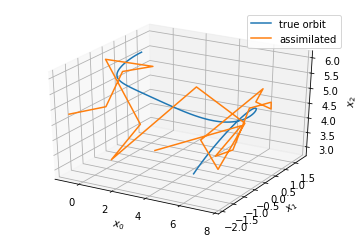

Before assimilation
cost 454.146512431


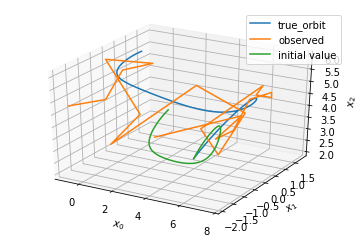

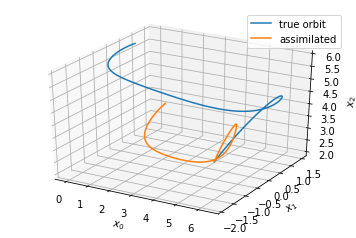

Analytical and numerical gradient comparison
gr_anal [ -16.32648033   -8.29770735   55.74466755  -47.58502248  -39.65633122
  -56.24586519   15.33932735  -34.24249035   98.11765734 -121.938782  ]
gr_num [ -15.64948504   -8.34974917   47.06011364  -37.0327857   -36.54348886
  -42.69294008   12.0059762   -34.78850991   97.84553806 -114.72179434]
relative error [ 0.04325991 -0.00623274  0.18454171  0.2849431   0.08518186  0.3174512
  0.27764099 -0.0156954   0.00278111  0.0629086 ]
      fun: 67.068663690569522
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.40139041, -0.13262248, -0.02015516,  0.31173685, -0.14302125,
       -0.1666696 , -0.1217108 , -0.04733069,  2.21992808,  1.45205454])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 106
      nit: 35
   status: 0
  success: True
        x: array([ 5.63802596, -0.93114329,  3.56330586,  3.2847562 , -1.78175978,
       -0.07987659,  2.64732259,  7.35741767,  0.98170946, -0.79368271

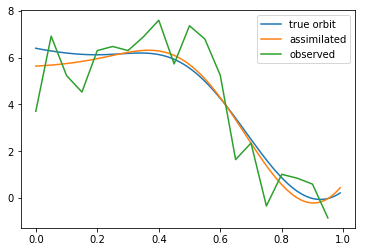

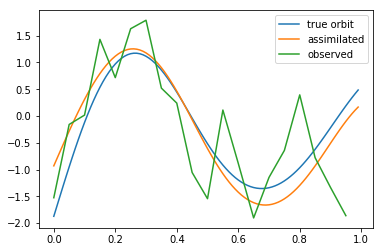

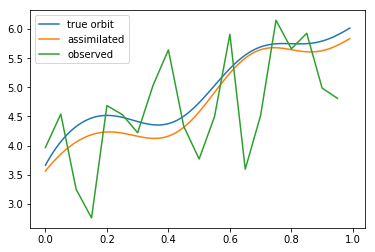

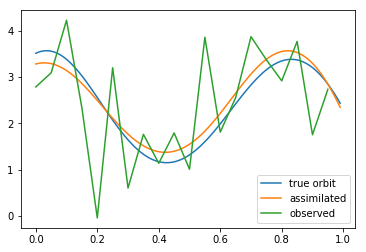

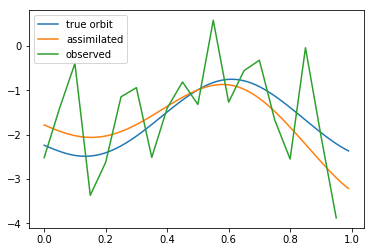

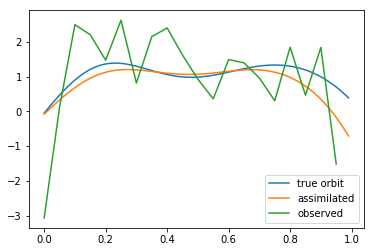

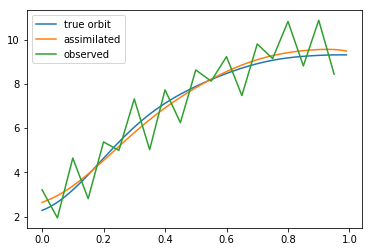

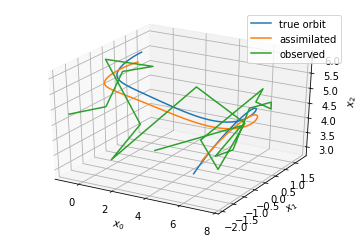

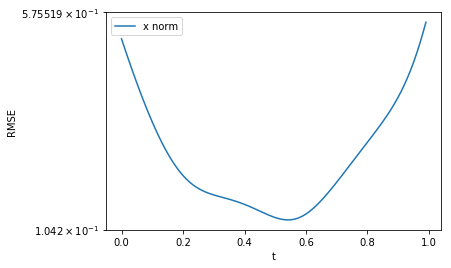

RMSE: 0.137355590664
RMSE_natural_variability: 5.29043166363
4DVar optimal cost:  67.0686636906


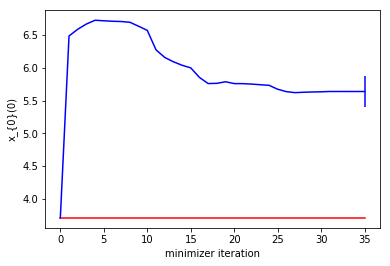

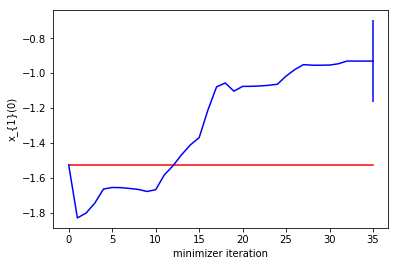

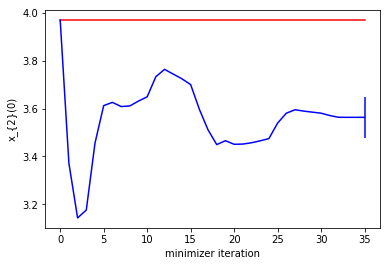

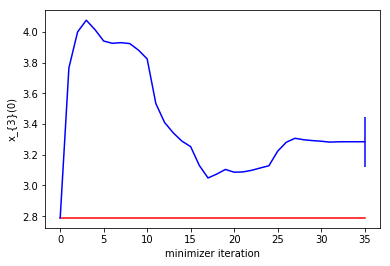

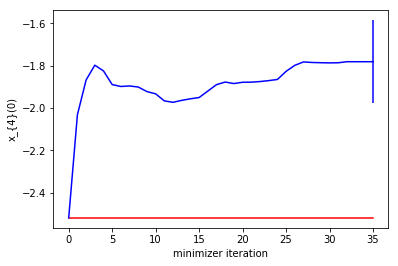

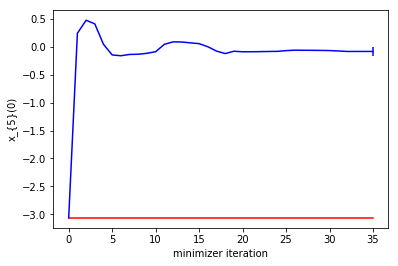

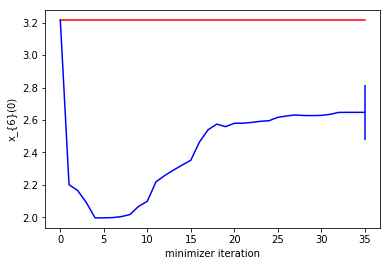

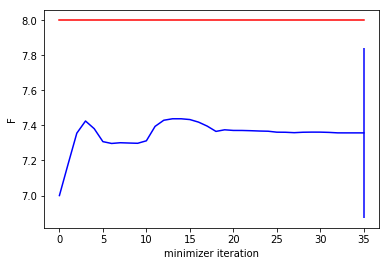

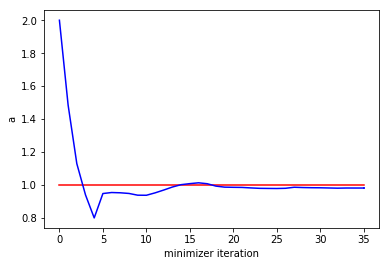

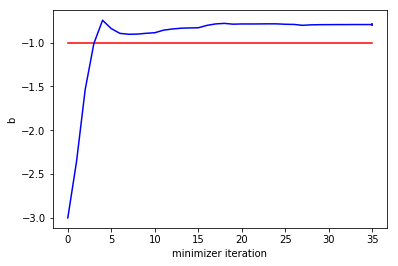

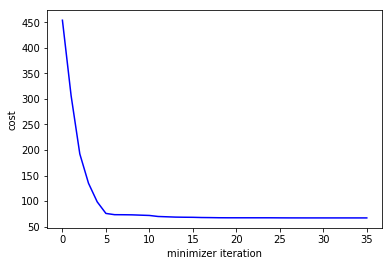

True_Param: [ 8.  1. -1.]
Estimated_Param: [ 7.35741767  0.98170946 -0.79368271]
RMSE_Param: 0.389792004667


In [13]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 14 17:01:40 2017

@author: yk
"""

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import math

count = 0

def handler(func, *args):
    return func(*args)

#%%
class Lorenz96:
    def __init__(self, N):
        self.N = N # number of variables
        self.M = 3 # number of parameters
        self.m = np.zeros((self.N + self.M, self.N + self.M))
    def gradient(self,x):
        d = np.zeros(self.N + self.M)
        d[0]        = x[self.N+1] * (x[1]   - x[self.N-2]) * x[self.N-1] + x[self.N+2] * x[0]        + x[self.N]
        d[1]        = x[self.N+1] * (x[2]   - x[self.N-1]) * x[0]        + x[self.N+2] * x[1]        + x[self.N]
        for i in range(2, self.N-1):
            d[i]    = x[self.N+1] * (x[i+1] - x[i-2])      * x[i-1]      + x[self.N+2] * x[i]        + x[self.N]
        d[self.N-1] = x[self.N+1] * (x[0]   - x[self.N-3]) * x[self.N-2] + x[self.N+2] * x[self.N-1] + x[self.N]
        return d

    def tl(self, x):
        self.m.fill(0.)
        for i in range(self.N):
            for j in range(self.N):
                if (((i-1) % self.N) == j):
                    self.m[i][j] += x[self.N+1] * (x[(i+1) % self.N] - x[(i-2) % self.N])
                if (((i+1) % self.N) == j):
                    self.m[i][j] += x[self.N+1] * x[(i-1) % self.N]
                if (((i-2) % self.N) == j):
                    self.m[i][j] -= x[self.N+1] * x[(i-1) % self.N]
                if ((i     % self.N) == j):
                    self.m[i][j] += x[self.N+2]
            self.m[i][N] = 1
            self.m[i][N+1] = (x[(i+1) % self.N] - x[(i-2) % self.N]) * x[(i-1) % self.N]
            self.m[i][N+2] = x[i]

    def gradient_tl(self, xi, x):
        self.tl(x)
        return self.m @ xi
        
    def gradient_tl_T(self, nu, x):
        self.tl(x)
        return self.m.transpose() @ nu
    
    def gradient_adjoint(self, la, x):
        # same as gradient_tl_T
        mt = np.zeros((self.N + self.M ,self.N + self.M))
        for i in range(self.N):
            for j in range(self.N):
                if (((i-1) % self.N) == j):
                    mt[j][i] += x[self.N+1] * (x[(i+1) % self.N] - x[(i-2) % self.N])
                if (((i+1) % self.N) == j):
                    mt[j][i] += x[self.N+1] * x[(i-1) % self.N]
                if (((i-2) % self.N) == j):
                    mt[j][i] -= x[self.N+1] * x[(i-1) % self.N]
                if ((i     % self.N) == j):
                    mt[j][i] += x[self.N+2]
            mt[N][i] = 1
            mt[N+1][i] = (x[(i+1) % self.N] - x[(i-2) % self.N]) * x[(i-1) % self.N]
            mt[N+2][i] = x[i]
        gr = mt @ la
        return gr
    
    def gradient_secondadj(self, nu, x, la, xi):
        self.tl(x)
        gr = np.zeros(self.N + self.M)
        for i in range(self.N):
            gr[i] = (x[(i+1) % self.N] - x[(i-2) % self.N]) * (xi[(i-1) % self.N] * la[self.N+1] + xi[self.N+1] * la[(i-1) % self.N])\
            + x[self.N+1] * (xi[(i-1) % self.N] * (la[(i+1) % self.N] - la[(i-2) % self.N]) + la[(i-1) % self.N] * (xi[(i+1) % self.N] - xi[(i-2) % self.N]))\
            + x[(i-1) % self.N] * ((xi[(i+1) % self.N] - xi[(i-2) % self.N]) * la[self.N+1] + (la[(i+1) % self.N] - la[(i-2) % self.N]) * xi[self.N+1])\
            + la[self.N+2] * xi[i] + xi[self.N+2] * la[i]
        return gr + self.gradient_tl_T(nu, x)

class Adjoint:
    def __init__(self, dx, dla, dxi, dnu, N, T, dt, it, x, y, la, xi, nu):
        self.dx = dx
        self.dla = dla
        self.dxi = dxi
        self.dnu = dnu
        self.N = N
        self.T = T
        self.dt = dt
        self.x = x
        self.y = y
        self.la = la
        self.xi = xi
        self.nu = nu
        self.it = it
        self.minute_steps = int(T/self.dt)
        self.steps = int(self.minute_steps/it)
        self.M = 3
        self.xgr = np.zeros((self.minute_steps, self.N + self.M))
        self.lagr = np.zeros((self.minute_steps, self.N + self.M))
        self.xigr = np.zeros((self.minute_steps, self.N + self.M))
        
    def orbit(self):
        for i in range(self.minute_steps-1):
            k1 = handler(self.dx, self.x[i])
            k2 = handler(self.dx, self.x[i] + k1*self.dt/2)
            k3 = handler(self.dx, self.x[i] + k2*self.dt/2)
            k4 = handler(self.dx, self.x[i] + k3*self.dt)
            self.xgr[i] = (k1 + 2*k2 + 2*k3 + k4)/6.
            self.x[i+1] = self.x[i] + self.xgr[i] * self.dt
        return self.x

    def neighboring(self):
        for i in range(self.minute_steps-1):
            k1 = handler(self.dxi, self.xi[i]                , self.x[i]                           )
            k2 = handler(self.dxi, self.xi[i] + k1*self.dt/2., self.x[i] + self.xgr[i] * self.dt/2.)
            k3 = handler(self.dxi, self.xi[i] + k2*self.dt/2., self.x[i] + self.xgr[i] * self.dt/2.)
            k4 = handler(self.dxi, self.xi[i] + k3*self.dt   , self.x[i+1])
            self.xigr[i] = (k1 + 2*k2 + 2*k3 + k4)/6.
            self.xi[i+1] = self.xi[i] + self.xigr[i] * self.dt
        return self.xi
    
    def observed(self, stddev):
        self.orbit()
        for i in range(self.steps):
            for j in range(self.N):
                self.x[i,j] += stddev * np.random.randn() # fixed
        return self.x

    def true_observed(self, stddev):
        tob = np.copy(self.orbit())
        for i in range(self.steps):
            for j in range(self.N):
                self.x[i,j] += stddev * np.random.randn() # fixed
        return tob, self.x
    
    def gradient_from_x0(self, x0):
        self.x[0] = x0
        self.orbit()
        self.la.fill(0.)
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                if (n < self.it*self.steps - 1):
                    p1 = handler(self.dx, self.x[n])
                    p2 = handler(self.dx, self.x[n] + p1*self.dt/2)
                    p3 = handler(self.dx, self.x[n] + p2*self.dt/2)
                    p4 = handler(self.dx, self.x[n] + p3*self.dt)
                    gr = (p1 + 2*p2 + 2*p3 + p4)/6
    
                    k1 = handler(self.dla, self.la[n+1], self.x[n+1])
                    k2 = handler(self.dla, self.la[n+1] - k1*self.dt/2, self.x[n+1] - gr*self.dt/2)
                    k3 = handler(self.dla, self.la[n+1] - k2*self.dt/2, self.x[n+1] - gr*self.dt/2)
                    k4 = handler(self.dla, self.la[n+1] - k3*self.dt, self.x[n])
                    self.lagr[n] = (k1 + 2*k2 + 2*k3 + k4)/6.
                    self.la[n] = self.la[n+1] + self.lagr[n] * self.dt
            for j in range(self.N):
                self.la[self.it*i][j] += self.x[self.it*i][j] - self.y[i][j]
        return self.la[0]
    
    def hessian_vector_product(self, xi0):
        self.xi[0] = np.copy(xi0)
        self.neighboring()
        self.nu.fill(0.)
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                if (n < self.it*self.steps - 1):
                    k1 = handler(self.dnu, self.nu[n+1]                , self.x[n+1]                         , self.la[n+1]                          , self.xi[n+1])
                    k2 = handler(self.dnu, self.nu[n+1] - k1*self.dt/2., self.x[n+1] - self.xgr[n]*self.dt/2., self.la[n+1] + self.lagr[n]*self.dt/2., self.xi[n+1] - self.xigr[n]*self.dt/2.)
                    k3 = handler(self.dnu, self.nu[n+1] - k2*self.dt/2., self.x[n+1] - self.xgr[n]*self.dt/2., self.la[n+1] + self.lagr[n]*self.dt/2., self.xi[n+1] - self.xigr[n]*self.dt/2.)
                    k4 = handler(self.dnu, self.nu[n+1] - k3*self.dt   , self.x[n]                           , self.la[n+1] + self.lagr[n]*self.dt   , self.xi[n])
                    self.nu[n] = self.nu[n+1] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
            for j in range(self.N):
                self.nu[self.it*i][j] += self.xi[self.it*i][j]        
        return self.nu[0]
    
    def cost(self, x0):
        self.x[0] = x0
        self.orbit()
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps):
            cost += (self.x[self.it*i][0:self.N] - self.y[i]) @ (self.x[self.it*i][0:self.N] - self.y[i])
        return cost/2.0 # fixed
    
    def true_cost(self):
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps):
            cost += (self.x[self.it*i][0:self.N] - self.y[i]) @ (self.x[self.it*i][0:self.N] - self.y[i])
        return cost/2.0 # fixed
    
    def numerical_gradient_from_x0(self,x0,h):
        gr = np.zeros(self.N + self.M)
        c1 = self.cost(x0)
        for j in range(self.N + self.M):
            xx = np.copy(x0)
            xx[j] += h
            c = self.cost(xx)
            gr[j] = (c - c1)/h
        return gr
    
    def cbf(self, x0):
#        global axL, axR, axRR
        global count, trace, f_trace, a_trace, b_trace, cost_trace
        count += 1
        cos = self.cost(x0)
#        axLL.scatter(count, x0[self.N], c='b')
#        axL.scatter(count, x0[self.N+1], c='b')
#        axR.scatter(count, x0[self.N+2], c='b')
#        axRR.scatter(count, cos, c='b')
        f_trace.append(x0[self.N])
        a_trace.append(x0[self.N+1])
        b_trace.append(x0[self.N+2])
        cost_trace.append(cos)
        for i in range(self.N):
            trace[i].append(x0[i])

#%%
def plot_orbit(dat):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat[:,0],dat[:,1],dat[:,2])
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.show()

def compare_orbit(dat1, dat2):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label='true orbit')
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label='assimilated')
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

def compare_orbit3(dat1, dat2, dat3, label1, label2, label3):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label=label1)
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label=label2)
    ax.plot(dat3[:,0],dat3[:,1],dat3[:,2],label=label3)
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

    
#%%
from scipy.optimize import minimize

N = 7
pref = "/Users/konta/bitbucket/androsace/dacamp/task1/data/" + str(N) + "/"

M = 3
F = 8
year = 0.01


day = 365 * year
dt = 0.01

# T = day * 0.2
T = 1.0
print("T", T)
print("day", T/0.2)
it = 5
minute_steps = int(T/dt)
steps = int(minute_steps/it)

stddev = 1

lorenz = Lorenz96(N)

tob = np.loadtxt(pref + "year.1.dat")
tob2 = np.loadtxt(pref + "year.2.dat")
#covariance_tob = np.cov(np.transpose(np.asarray(tob[0:minute_steps])))
#root_mean_trace_cov_tob = np.sqrt(np.trace(covariance_tob)/N)

RMSE_natural_variability = np.mean([np.linalg.norm(tob2[i] - tob[i])/math.sqrt(N) for i in range(0,len(tob))])
#RMSE_natural_variability_T = np.mean([np.linalg.norm(tob2[i] - tob[i])/math.sqrt(N) for i in range(0,minute_steps)])

obs = np.loadtxt(pref + "observed." + str(it) + ".1.dat")
#covariance_obs = np.cov(np.transpose(np.asarray(obs[0:steps])))
#root_mean_trace_cov_obs = np.sqrt(np.trace(covariance_obs)/N)

compare_orbit(tob[0:minute_steps], obs[0:steps])

t = np.arange(0., T, dt)
t_it = np.arange(0., T, dt*it)

x_opt = np.zeros(N + M)
#x_opt[0:N] = np.loadtxt(pref + "year.2.dat")[np.random.randint(len(tob))]
x_opt[0:N] = np.copy(tob[0])
x_opt[N] = 7 # initial guess for F
x_opt[N+1] = 2 # initial guess for a
x_opt[N+2] = -3 # initial guess for b

x = np.zeros((minute_steps, N + M))
la = np.zeros((minute_steps, N + M))
xi = np.zeros((minute_steps, N + M))
nu = np.zeros((minute_steps, N + M))
scheme = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, lorenz.gradient_tl, lorenz.gradient_secondadj, N, T, dt, it, x, obs, la, xi, nu)

print("Before assimilation")
initial_cost = scheme.cost(x_opt)
print("cost", initial_cost)
compare_orbit3(tob[0:minute_steps], obs[0:steps], scheme.x[:,0:N], 'true_orbit', 'observed', 'initial value')
compare_orbit(tob[0:minute_steps], scheme.x[:,0:N])

print("Analytical and numerical gradient comparison")
gr_anal = scheme.gradient_from_x0(x_opt)
print ("gr_anal", gr_anal)
gr_num = scheme.numerical_gradient_from_x0(x_opt, 0.00001)
print ("gr_num", gr_num)
print ("relative error", (gr_anal - gr_num)/gr_num)

#%%
#fig , (axLL, axL, axR, axRR) = plt.subplots(ncols=4, figsize=(10,4), sharex=False)
f_trace = [x_opt[N]]
a_trace = [x_opt[N+1]]
b_trace = [x_opt[N+2]]
cost_trace = [initial_cost]
trace=[]
for i in range(N):
    trace.append([obs[0,i]])
res = minimize(scheme.cost, x_opt, jac=scheme.gradient_from_x0, method='L-BFGS-B', callback=scheme.cbf)

#%%
print (res)
print ("true x0", tob[0])

#%%
hessian_T = np.zeros((N + M, N + M))
xi0 = np.zeros(N + M)
for i in range(N + M):
    xi0.fill(0.)
    xi0[i] = 1.
    hessian_T[i] = np.copy(scheme.hessian_vector_product(xi0))

hessian = hessian_T.transpose()
hessian_inv = np.linalg.inv(hessian)
print("hessian", hessian)
print("hessian_inverse", hessian_inv)
variance = np.diag(hessian_inv)
print("variance", variance)

#%%    

#for j in range(3):
for j in range(N):
    fig = plt.figure()
    plt.plot(t, tob[0:minute_steps,j], label='true orbit')
    plt.plot(t, scheme.x[0:minute_steps,j], label='assimilated')
    plt.plot(t_it, obs[0:steps, j], label='observed')
    plt.legend()
    plt.show()

compare_orbit3(tob[0:minute_steps], scheme.x[:,0:N], obs[0:steps], 'true orbit', 'assimilated', 'observed')

#%%
fig = plt.figure()
plt.plot(t, [np.linalg.norm(scheme.x[i,0:N] - tob[i])/math.sqrt(N) for i in range(len(t))], label='x norm')
plt.xlabel('t')
plt.ylabel('RMSE')
plt.yscale('symlog')
plt.legend()
plt.show()

print ("RMSE:", np.mean([np.linalg.norm(scheme.x[i,0:N] - tob[i])/math.sqrt(N) for i in range(int(len(t)*0.4),int(len(t)*0.6))]))
#print ("RootMeanTr(cov(true)):", root_mean_trace_cov_tob)
#print ("RootMeanTr(cov(obs)):", root_mean_trace_cov_obs)
print ("RMSE_natural_variability:", RMSE_natural_variability)
#print ("RMSE_natural_variability_T:", RMSE_natural_variability_T)

print('4DVar optimal cost: ', res.fun)
#scheme_true = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, N, T, dt, it, tob, obs)
#print('true cost: ', scheme_true.true_cost())

#%%
for j in range(N):
    plt.plot([obs[0,j] for i in range(len(trace[j]))], 'r')
    plt.plot(trace[j], 'b')
    plt.errorbar(len(trace[j])-1, trace[j][-1], yerr=hessian_inv[j,j], fmt='b')
    plt.legend()
    plt.xlabel('minimizer iteration')
    plt.ylabel('x_{' + str(j) + '}(0)')
    plt.show()

true_param = np.array([8., 1., -1.])

fig = plt.figure()
plt.plot([true_param[0] for i in range(len(f_trace))], 'r')
plt.plot(f_trace, 'b')
plt.errorbar(len(f_trace)-1, f_trace[-1], yerr=hessian_inv[N,N], fmt='b')
plt.legend()
plt.xlabel('minimizer iteration')
plt.ylabel('F')
plt.show()

fig = plt.figure()
plt.plot([true_param[1] for i in range(len(a_trace))], 'r')
plt.plot(a_trace, 'b')
plt.errorbar(len(a_trace)-1, a_trace[-1], yerr=hessian_inv[N+1,N+1], fmt='b')
plt.legend()
plt.xlabel('minimizer iteration')
plt.ylabel('a')
plt.show()

fig = plt.figure()
plt.plot([true_param[2] for i in range(len(b_trace))], 'r')
plt.plot(b_trace, 'b')
plt.errorbar(len(b_trace)-1, b_trace[-1], yerr=hessian_inv[N+2,N+2], fmt='b')
plt.legend()
plt.xlabel('minimizer iteration')
plt.ylabel('b')
plt.show()

fig = plt.figure()
plt.plot(cost_trace, 'b')
plt.xlabel('minimizer iteration')
plt.ylabel('cost')
plt.show()

param_rmse = np.linalg.norm(res.x[N:N+M] - true_param)/math.sqrt(M)
print("True_Param:", true_param)
print("Estimated_Param:", res.x[N:N+M])
print ("RMSE_Param:", param_rmse)
#%%
#slight_different_x0 = np.zeros(N + M)
#slight_different_x0[0:N] = np.copy(tob[0])
#slight_different_x0[N] = 8
#slight_different_x0[N+1] = 1
#slight_different_x0[N+2] = -1
#slight_different_x0[0] += 0.01
#rk4 = RungeKutta4(lorenz.gradient, N, dt, t, slight_different_x0)
#test_T = 2.0
#slight_different_orb = rk4.orbit(test_T)
#curr_steps = int(test_T/dt)
#
#compare_orbit(tob[0:curr_steps], slight_different_orb[0:curr_steps,0:N])


- 初期値とパラメータによるCost functionのHessian matrixが対称行列にならない→おそらくバグがある
- 推定値が、信頼区間に入っていない

# 来週の目標
- 二次変分によるパラメータと状態変数の信頼区間推定の完成
- 黒田研実データへの適用
- システムノイズ(なし/あり)固定区間スムーザーの実装
- 見た目ではなく、正しいことがわかるようなvalidationの図を